# Load Dataset

In [1]:
import pandas as pd
import os
import numpy as np
from pprint import pprint

In [37]:
from pathlib import Path

def load_data(directory, nrows=None):
# Read each CSV file in dir "path/to/root_dir"
    dfs = []
    for file in Path(directory).glob('**/*.csv'):
        dfs.append(pd.read_csv(file, nrows=nrows))
    # Put the dataframes to a single dataframe
    df = pd.concat(dfs, ignore_index=True)
    return df

malware_dir = os.path.join(os.getcwd(), 'dataset', 'Malware')

df = load_data(malware_dir, nrows=None)

# shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)

# trim columns labels
df.columns = df.columns.str.strip()

# Drop "MALWARE" or NaN rows
df.drop(df[(df['Label'] == "MALWARE") | (df["Label"] == "BENIGN")].index, inplace = True)
# df.drop(df[df['Label'] == "BENIGN"].index, inplace = True)
df.dropna(inplace=True)

df.head()

In [38]:
df.shape

(202100, 85)

<AxesSubplot: xlabel='Label', ylabel='# occurrences'>

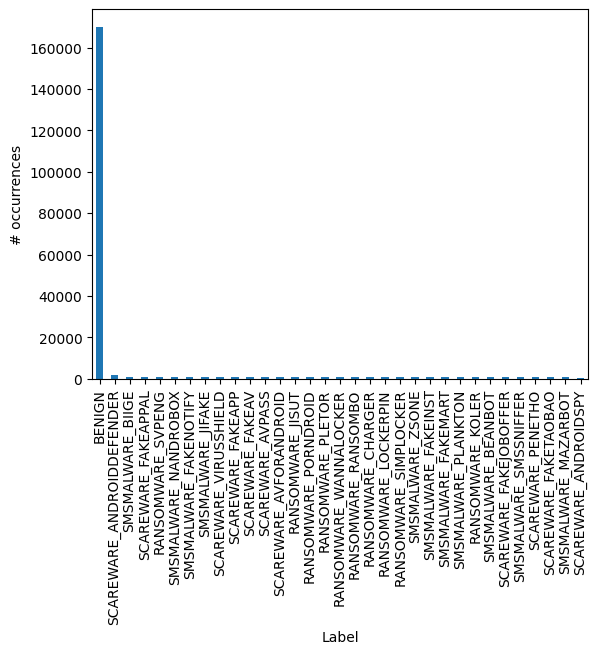

In [36]:
df["Label"].value_counts().plot(
    kind="bar",
    xlabel="Label",
    ylabel="# occurrences"
)

# Data Preprocessing

In [7]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df['Source IP'] = label_encoder.fit_transform(df['Source IP'])
    df['Flow ID'] = label_encoder.fit_transform(df['Flow ID'])
    df['Destination IP'] = label_encoder.fit_transform(df['Destination IP'])

    # drop column Timestamp
    df = df.drop(['Timestamp'], axis=1)
    df = df.dropna()
    return df

df = data_preprocessing(df)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Label'], axis=1),
    df['Label'],
    test_size=0.4,
    random_state=42
)

#p = 0.8
#train_df, test_df = df[:int(len(df)*p)], df[int(len(df)*p):]

X_train.shape, X_test.shape

((1315452, 83), (876968, 83))

In [10]:
X_train.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
100292,11877,8,34929,3955,80,6,1329099,30,42,1220.0,...,10,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179055,65331,10,41594,5809,80,6,55877,5,3,131.0,...,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293578,17574,9,60656,62,80,6,6915111,2,0,0.0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250734,137065,10,33110,2084,80,6,11043,2,0,0.0,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273766,13746,8,33863,5386,443,6,52912,1,1,0.0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
y_train.head()

100292     BENIGN
179055    MALWARE
293578    MALWARE
250734     BENIGN
273766     BENIGN
Name: Label, dtype: object

# Valutazione

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title='Confusion matrix')


# Decision Tree

In [11]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)

[Text(0.5, 0.875, 'Source IP <= 22.5\ngini = 0.495\nsamples = 1315452\nvalue = [725988, 589464]\nclass = BENIGN'),
 Text(0.25, 0.625, 'Flow ID <= 189365.5\ngini = 0.5\nsamples = 780453\nvalue = [391162, 389291]\nclass = BENIGN'),
 Text(0.125, 0.375, 'Fwd IAT Std <= 207569.68\ngini = 0.491\nsamples = 173671\nvalue = [75285, 98386]\nclass = MALWARE'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Destination Port <= 5242.0\ngini = 0.499\nsamples = 606782\nvalue = [315877, 290905]\nclass = BENIGN'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Source IP <= 2097.5\ngini = 0.468\nsamples = 534999\nvalue = [334826, 200173]\nclass = BENIGN'),
 Text(0.625, 0.375, 'Source IP <= 1577.5\ngini = 0.46\nsamples = 453081\nvalue = [290851, 162230]\nclass = BENIGN'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Destination IP <= 42.0\ngini = 0.4

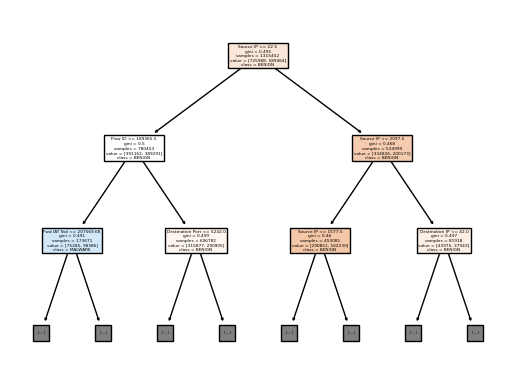

In [12]:
tree.plot_tree(decision_tree, filled=True, class_names=decision_tree.classes_, feature_names=X_train.columns, max_depth=2)

              precision    recall  f1-score   support

      BENIGN       0.75      0.73      0.74    484221
     MALWARE       0.67      0.69      0.68    392747

    accuracy                           0.71    876968
   macro avg       0.71      0.71      0.71    876968
weighted avg       0.71      0.71      0.71    876968



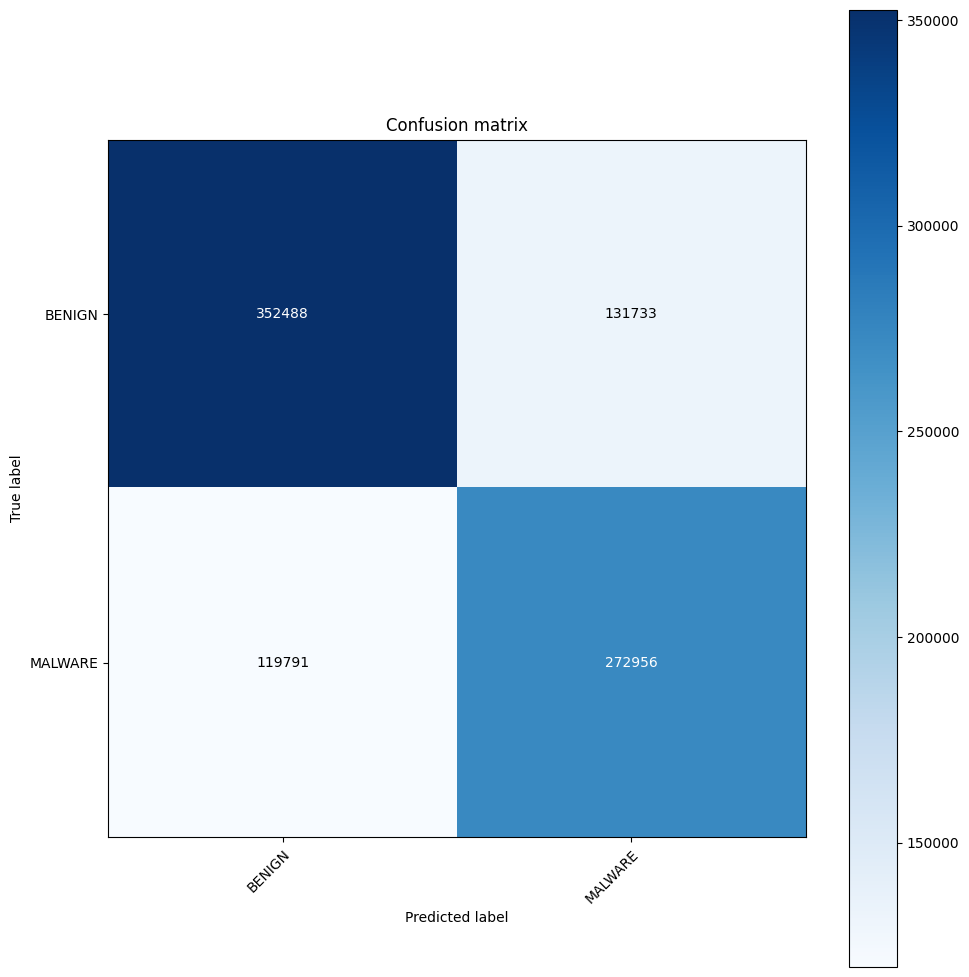

In [13]:
valuate(decision_tree, X_test, y_test)

In [14]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    decision_tree,
    X_train,
    y_train,
    cv=10,
    scoring=['precision_macro', 'recall_macro']
)

In [15]:
print(f'{10}-fold cross validation:')
print('Precision: %0.2f (+/- %0.2f)' % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2))
print('Recall: %0.2f (+/- %0.2f)' % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2))

10-fold cross validation:
Precision: 0.75 (+/- 0.01)
Recall: 0.75 (+/- 0.00)


# KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [11]:
valuate(knn, X_test, y_test)

# Support Vector Machine

In [14]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

C=1.0
models = (
    # svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=1000, dual=True),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    #svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = [clf.fit(X_train[:10_000], y_train[:10_000]) for clf in models]

/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC:
              precision    recall  f1-score   support

      BENIGN       0.57      0.31      0.40      2311
     MALWARE       0.42      0.69      0.52      1689

    accuracy                           0.47      4000
   macro avg       0.50      0.50      0.46      4000
weighted avg       0.51      0.47      0.45      4000

SVC:
              precision    recall  f1-score   support

      BENIGN       0.58      1.00      0.73      2311
     MALWARE       1.00      0.01      0.02      1689

    accuracy                           0.58      4000
   macro avg       0.79      0.51      0.38      4000
weighted avg       0.76      0.58      0.43      4000



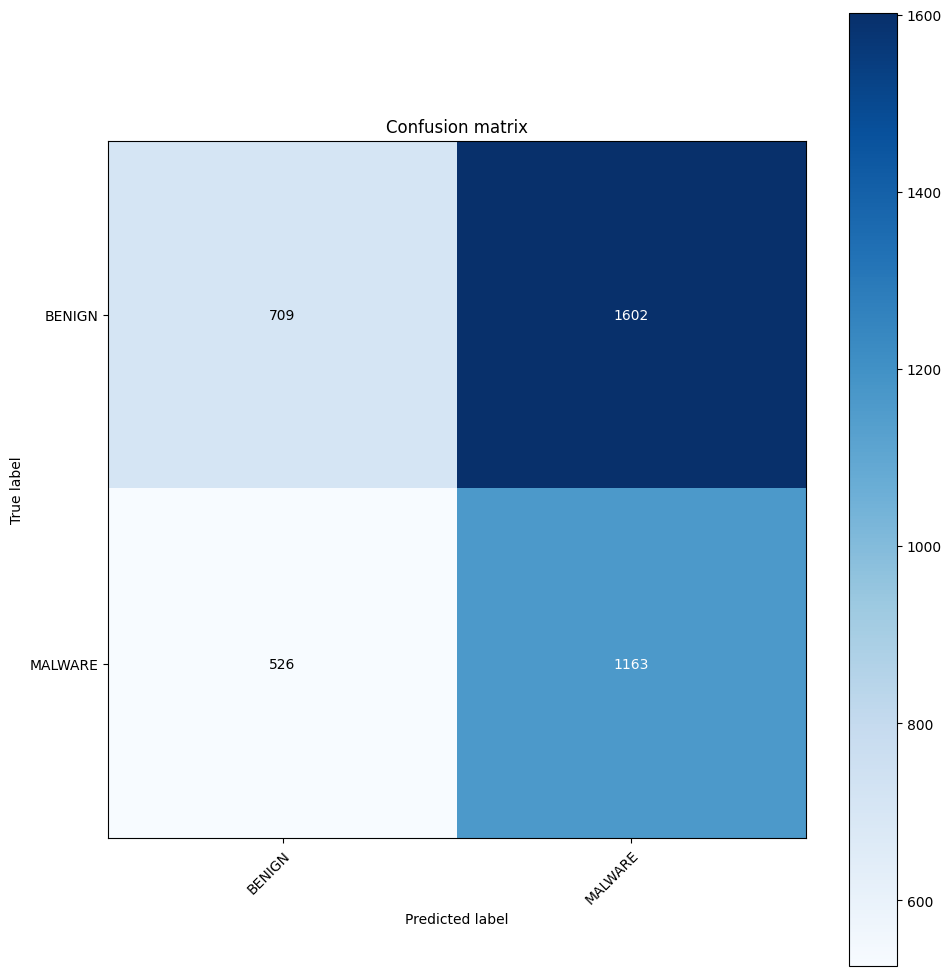

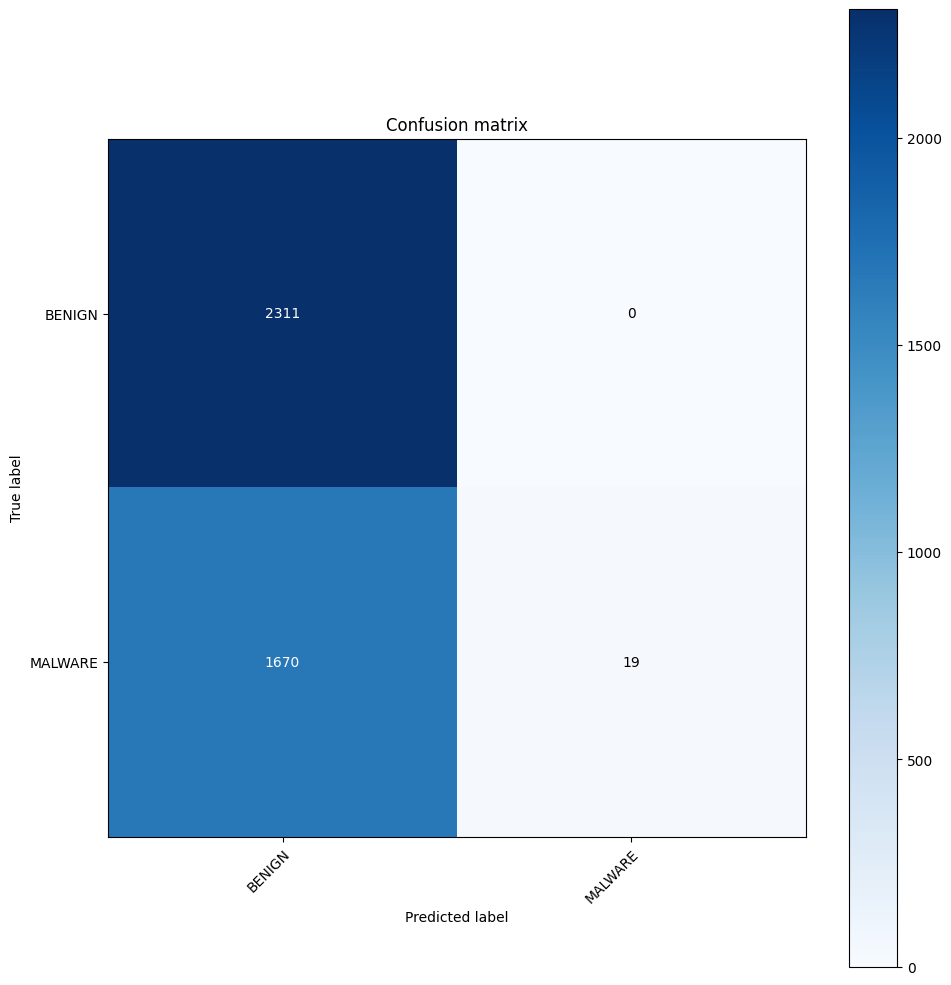

In [15]:
# valuate models

for clf in models:
    # print scores 
    print(f'{clf.__class__.__name__}:')
    valuate(clf, X_test[:4_000], y_test[:4_000])

# Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      BENIGN       0.59      0.91      0.71     67991
     MALWARE       0.55      0.15      0.24     51410

    accuracy                           0.58    119401
   macro avg       0.57      0.53      0.47    119401
weighted avg       0.57      0.58      0.51    119401



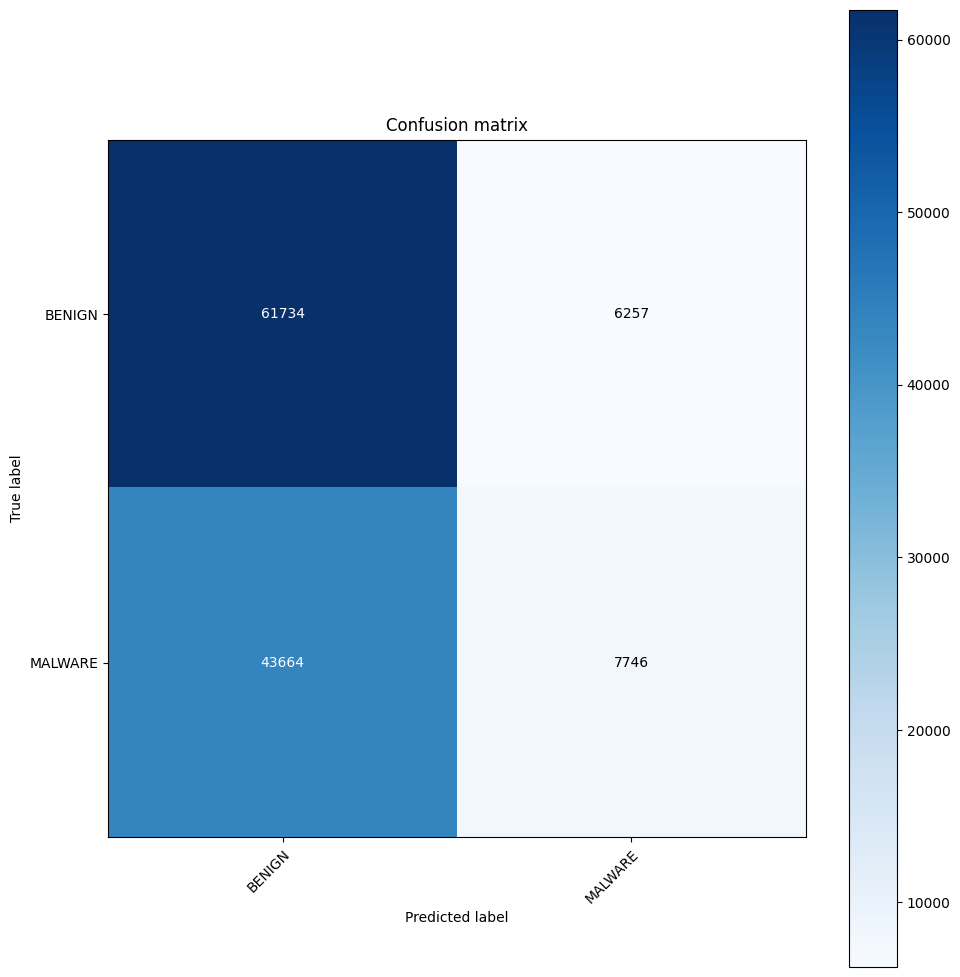

In [18]:
valuate(logistic_classifier, X_test, y_test)

# Gaussian Discriminant Analysis

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis().fit(X_train, y_train)

              precision    recall  f1-score   support

      BENIGN       0.59      0.89      0.71     67991
     MALWARE       0.58      0.19      0.29     51410

    accuracy                           0.59    119401
   macro avg       0.59      0.54      0.50    119401
weighted avg       0.59      0.59      0.53    119401



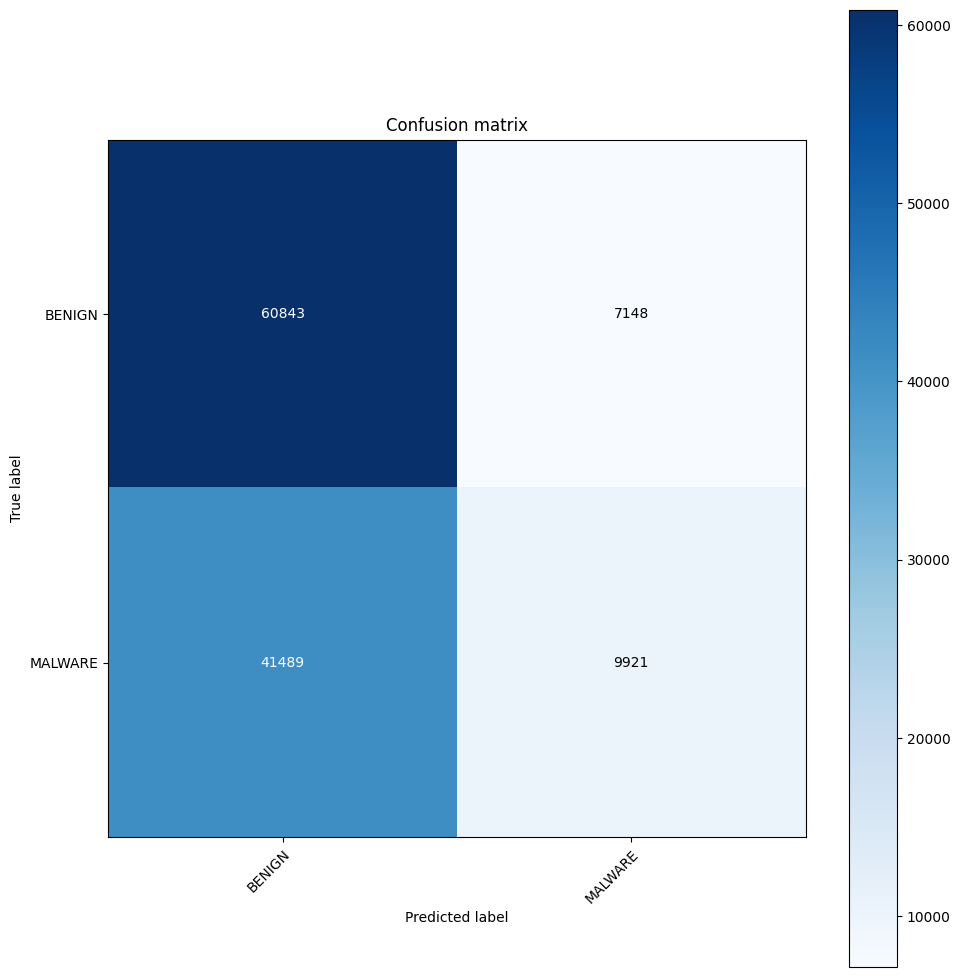

In [20]:
valuate(lda_classifier, X_test, y_test)

# MultiLayer Perceptron

In [114]:
from sklearn.decomposition import PCA
pca = PCA(n_components=32)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [115]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [116]:
from torch.utils.data import Dataset, DataLoader

class NetworkDataset(Dataset):
    def __init__(self, data, target):
        #self.data = data.to_numpy()
        self.data = data
        self.target = label_encoder.fit_transform(target)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]
    

train_dataset = NetworkDataset(X_train_reduced, y_train)
test_dataset = NetworkDataset(X_test_reduced, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [117]:
import torch.nn as nn
import torch.nn.functional as F

class NetworkNN(nn.Module):

    def __init__(self):
        super(NetworkNN, self).__init__()
        # self.fc1 = nn.Linear(83, 64)
        # self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 5)
        self.fc5 = nn.Linear(5, 2)
        self.logits = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = self.logits(x)
        return x
    
class NetworkNN2(nn.Module):
    def __init__(self, w, h, num_classes):
        super(NetworkNN2, self).__init__()
        self.f = nn.Flatten()
        self.l1 = nn.Linear(w*h, num_classes)   
        self.ls = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.f(x)
        out = self.l1(out)
        out = self.ls(out)
        return out
    
model = NetworkNN().to(device)
# model2 = NetworkNN2(83, 1, 2).to(device)
model2 = NetworkNN2(32, 1, 2).to(device)

In [118]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1} loss: {running_loss / len(dataloader)}')
    

In [120]:
train(model, train_dataloader, criterion, optimizer, epochs=10)

Epoch 1 loss: 2.636086460457141
Epoch 2 loss: 0.688989948655674
Epoch 3 loss: 0.683590408668811
Epoch 4 loss: 0.6835964393641276
Epoch 5 loss: 0.6836031497951575
Epoch 6 loss: 0.6835981339546304
Epoch 7 loss: 0.6836013377202583
Epoch 8 loss: 0.6836016099552633
Epoch 9 loss: 0.683603422370882
Epoch 10 loss: 0.6836020034651706


In [121]:
train(model2, train_dataloader, criterion, optimizer, epochs=5)

Epoch 1 loss: 2424440.9959360487
Epoch 2 loss: 2424352.2448419076
Epoch 3 loss: 2424290.8286888176
Epoch 4 loss: 2424306.076902465
Epoch 5 loss: 2424417.6438013576


In [96]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for _ in range(2))
class_total = list(0. for _ in range(2))

model.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.683236

Test Accuracy of     0: 100% (68091/68091)
Test Accuracy of     1:  0% ( 2/51310)

Test Accuracy (Overall): 57% (68093/119401)


### Plot uscito male

In [67]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)

models2 = (
    # svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000, dual=True),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    #svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)

models2 = (clf.fit(X_reduced[:5000], y_train[:5000]) for clf in models2)

/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


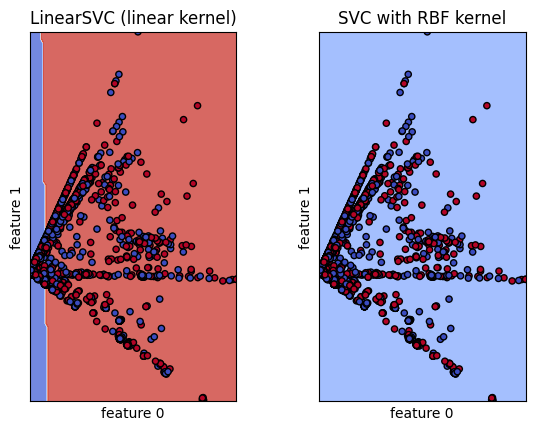

In [68]:
# title for the plots
titles = (
    #"SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    #"SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_reduced[:5000][:, 0] , X_reduced[:5000][:, 1]

for clf, title, ax in zip(models2, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_reduced[:5000],
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="feature 0",
        ylabel="feature 1",
    )

    # encode labels to 0, 1 classes
    y_labels = label_encoder.fit_transform(y_train[:5000])

    ax.scatter(X0, X1, c=y_labels, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()